In [71]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score 
import matplotlib.pyplot as plt
from sklearn.preprocessing import SplineTransformer

In [38]:
fires = pd.read_csv("fires.csv")

sub= fires[["wind", "temp", "area"]].dropna()
reference_X = sub[["wind", "temp"]]

reference = LinearRegression()

In [39]:
fires.isnull().sum()

Unnamed: 0     0
X              0
Y              0
month          0
day            0
FFMC          48
DMC           21
DC            43
ISI            2
temp          21
RH            30
wind          35
rain          32
area           0
dtype: int64

In [40]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [41]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


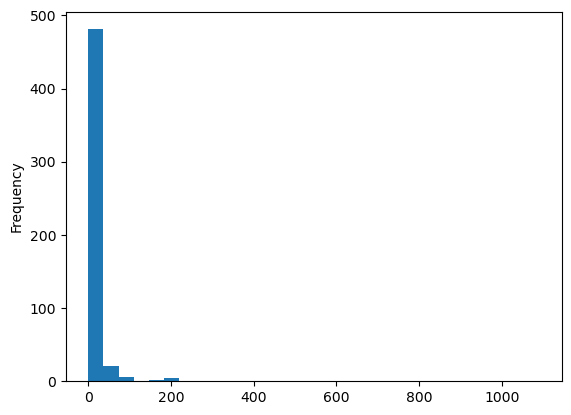

In [42]:
fires["area"].plot.hist( bins=30)
plt.show()

The column area is heavily right skewed, so it's better to create a log for of it.

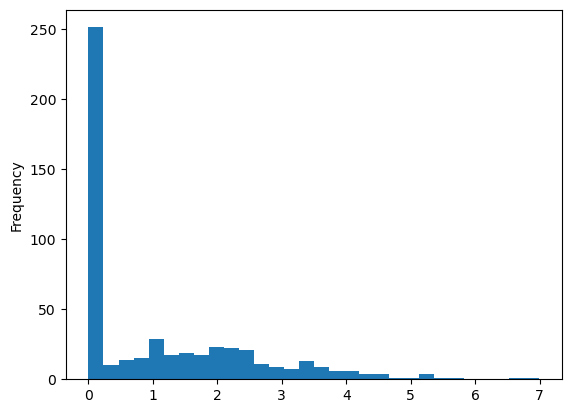

In [43]:
fires["log_area"]=np.log(fires["area"]+1)
fires["log_area"].plot.hist( bins=30)
plt.show()

Then we create the dummy for the variable moth, so we can use them as features. This just for the summer months, because there is a higher probability to have a fire during summer. 

In [44]:
cleaned_df=pd.concat([fires, pd.get_dummies(fires["month"])], axis=1)

In [45]:
cleaned_df=cleaned_df.drop(["dec","jan", "feb", "apr", "mar","may", "oct", "nov", "month"], axis=1)

In [46]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   day         517 non-null    object 
 4   FFMC        469 non-null    float64
 5   DMC         496 non-null    float64
 6   DC          474 non-null    float64
 7   ISI         515 non-null    float64
 8   temp        496 non-null    float64
 9   RH          487 non-null    float64
 10  wind        482 non-null    float64
 11  rain        485 non-null    float64
 12  area        517 non-null    float64
 13  log_area    517 non-null    float64
 14  aug         517 non-null    uint8  
 15  jul         517 non-null    uint8  
 16  jun         517 non-null    uint8  
 17  sep         517 non-null    uint8  
dtypes: float64(10), int64(3), object(1), uint8(4)
memory usage: 58.7+ KB


In [47]:
imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

missing_val = fires[cleaned_df.columns[4:11]] 
imp = pd.DataFrame(imp.fit_transform(missing_val), columns = cleaned_df.columns[4:11])
imp

,FFMC,DMC,DC,ISI,temp,RH,wind
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333
...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000


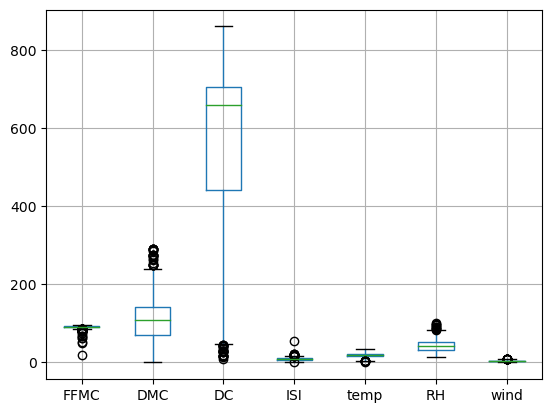

In [48]:
imp.boxplot()
plt.show()

In [49]:
for i in imp:
    percentile= [25, 50, 75]
    df_quart = np.percentile(fires[i], percentile)
    iqr = df_quart[2] - df_quart[0]
    lower_bound = df_quart[0] - (1.5 * iqr)
    upper_bound = df_quart[2] + (1.5 * iqr)
    num_outliers =sum((imp[i] < lower_bound) | (imp[i] > upper_bound))

    print(f"Number of outliers for the {i} column: {num_outliers}")

Number of outliers for the FFMC column: 0
Number of outliers for the DMC column: 0
Number of outliers for the DC column: 0
Number of outliers for the ISI column: 0
Number of outliers for the temp column: 0
Number of outliers for the RH column: 0
Number of outliers for the wind column: 0


In [50]:
scaler = StandardScaler()
scaled = scaler.fit_transform(imp)
scaled = pd.DataFrame(scaled, columns = cleaned_df.columns[4:11])

final_df = pd.concat([cleaned_df[["jun", "jul", "aug", "sep"]], scaled], axis=1)

final_df

,jun,jul,aug,sep,FFMC,DMC,DC,ISI,temp,RH,wind
0,0,0,0,0,-0.812224,-1.337000,-1.841182,-0.860187,-0.398943,0.419908,1.510163
1,0,0,0,0,-0.010676,-0.859829,0.509118,-0.508736,-0.156197,-0.714941,-1.763755
2,0,0,0,0,-0.010676,-1.060798,-0.301575,-0.508736,-0.745724,-0.714941,-1.537968
3,0,0,0,0,0.189710,-1.224941,-1.909876,-0.003526,-1.838083,3.320075,-0.013902
4,0,0,0,0,-0.247497,-0.940848,-1.808880,0.128267,-1.300573,3.446170,0.174254
...,...,...,...,...,...,...,...,...,...,...,...
512,0,0,1,0,-1.650205,-0.855620,0.494807,-1.563087,1.543028,-0.777988,-0.747712
513,0,0,1,0,-1.650205,-0.855620,0.494807,-1.563087,0.520026,1.680850,1.002141
514,0,0,1,0,-1.650205,-0.855620,0.494807,-1.563087,0.398652,1.617803,1.510163
515,0,0,1,0,0.681569,0.553796,0.286682,0.501683,1.161570,-0.147516,-0.013902


In [51]:
y = fires["log_area"]

lm = LinearRegression()

forward_2 = SequentialFeatureSelector(estimator=lm,n_features_to_select=2, direction="forward")

forward_4 = SequentialFeatureSelector(estimator=lm,n_features_to_select=4, direction="forward")

forward_6 = SequentialFeatureSelector(estimator=lm,n_features_to_select=6, direction="forward")
forward_8= SequentialFeatureSelector(estimator=lm,n_features_to_select=8, direction="forward")


forward_2.fit(final_df, y)
forward_4.fit(final_df, y)
forward_6.fit(final_df, y)
forward_8.fit(final_df, y)

print("Features selected with 2:", forward_2.get_feature_names_out())
print("Features selected with 4:", forward_4.get_feature_names_out())
print("Features selected with 6:", forward_6.get_feature_names_out())
print("Features selected with 8:", forward_8.get_feature_names_out())

Features selected with 2: ['FFMC' 'DC']
Features selected with 4: ['jul' 'FFMC' 'DC' 'wind']
Features selected with 6: ['jul' 'aug' 'sep' 'FFMC' 'DC' 'wind']
Features selected with 8: ['jul' 'aug' 'sep' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [52]:
backward_2 = SequentialFeatureSelector(estimator=lm,n_features_to_select=2, direction="backward")

backward_4 = SequentialFeatureSelector(estimator=lm,n_features_to_select=4, direction="backward")

backward_6 = SequentialFeatureSelector(estimator=lm,n_features_to_select=6, direction="backward")
backward_8= SequentialFeatureSelector(estimator=lm,n_features_to_select=8, direction="backward")


backward_2.fit(final_df, y)
backward_4.fit(final_df, y)
backward_6.fit(final_df, y)
backward_8.fit(final_df, y)

print("Features selected with 2:", backward_2.get_feature_names_out())
print("Features selected with 4:", backward_4.get_feature_names_out())
print("Features selected with 6:", backward_6.get_feature_names_out())
print("Features selected with 8:", backward_8.get_feature_names_out())

Features selected with 2: ['DC' 'wind']
Features selected with 4: ['jul' 'FFMC' 'DC' 'wind']
Features selected with 6: ['jul' 'aug' 'sep' 'FFMC' 'DC' 'wind']
Features selected with 8: ['jul' 'aug' 'sep' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


The features that we should used are the same for the forward and the backward method: jul, FFMC, DC and wind. 

In [53]:
ridge = RidgeCV(alphas = np.linspace(100, 1000, num=1000))
lasso = LassoCV(alphas = np.linspace(1000, 10000, num=1000))

ridge.fit(final_df, y)
lasso.fit(final_df, y)

print("Ridge alpha: ", ridge.alpha_)
print("LASSO alpha: ", lasso.alpha_)

print("Ridge coef: ", ridge.coef_)
print("LASSO coef: ", lasso.coef_)

Ridge alpha:  549.5495495495495
LASSO alpha:  10000.0
Ridge coef:  [-0.00651365 -0.00116202 -0.02529953  0.03463315  0.02049869  0.03710386
  0.02570377 -0.02568536  0.01876849 -0.02624878  0.05196865]
LASSO coef:  [-0. -0. -0.  0.  0.  0.  0. -0.  0. -0.  0.]


The Lasso coef is too extreme, so we will used the ridge one for the cross validation. 

In [54]:
sugg_cv= cross_val_score(lm, final_df[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
f2= cross_val_score(lm, final_df[forward_2.get_feature_names_out()] , y, cv = 5, scoring = "neg_mean_squared_error")
f4= cross_val_score(lm, final_df[forward_4.get_feature_names_out()] , y, cv = 5, scoring = "neg_mean_squared_error")
f6= cross_val_score(lm, final_df[forward_6.get_feature_names_out()] , y, cv = 5, scoring = "neg_mean_squared_error")
f8= cross_val_score(lm, final_df[forward_2.get_feature_names_out()] , y, cv = 5, scoring = "neg_mean_squared_error")
b2= cross_val_score(lm, final_df[backward_2.get_feature_names_out()] , y, cv = 5, scoring = "neg_mean_squared_error")
b4= cross_val_score(lm, final_df[backward_4.get_feature_names_out()] , y, cv = 5, scoring = "neg_mean_squared_error")
b6= cross_val_score(lm, final_df[backward_6.get_feature_names_out()] , y, cv = 5, scoring = "neg_mean_squared_error")
b8= cross_val_score(lm, final_df[backward_8.get_feature_names_out()] , y, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv= cross_val_score(ridge, final_df, y, cv = 5, scoring = "neg_mean_squared_error")


In [55]:
print("Sugg_cv mean and standard deviation of cv:", np.mean(sugg_cv), "|", np.std(sugg_cv))
print("F2 mean and standard deviation of cv:", np.mean(f2), "|", np.std(f2))
print("F4 mean and standard deviation of cv:", np.mean(f4), "|", np.std(f4))
print("F6 mean and standard deviation of cv:", np.mean(f6), "|", np.std(f6))
print("F8 mean and standard deviation of cv:", np.mean(f8), "|", np.std(f8))
print("B2 mean and standard deviation of cv:", np.mean(b2), "|", np.std(b2))
print("B4 mean and standard deviation of cv:", np.mean(b4), "|", np.std(b4))
print("B6 mean and standard deviation of cv:", np.mean(b6), "|", np.std(b6))
print("B8 mean and standard deviation of cv:", np.mean(b8), "|", np.std(b8))
print("Ridge_cv mean and standard deviation of cv:", np.mean(ridge_cv), "|", np.std(ridge_cv))

Sugg_cv mean and standard deviation of cv: -2.205048472539709 | 1.0605283983641134
F2 mean and standard deviation of cv: -2.17433093631593 | 1.021216598545506
F4 mean and standard deviation of cv: -2.1850321670226167 | 1.0030782086580101
F6 mean and standard deviation of cv: -2.2133992952124544 | 1.0000904332316793
F8 mean and standard deviation of cv: -2.17433093631593 | 1.021216598545506
B2 mean and standard deviation of cv: -2.175028090235512 | 1.005468961855031
B4 mean and standard deviation of cv: -2.1850321670226167 | 1.0030782086580101
B6 mean and standard deviation of cv: -2.2133992952124544 | 1.0000904332316793
B8 mean and standard deviation of cv: -2.2340159139370264 | 0.9934328301383343
Ridge_cv mean and standard deviation of cv: -2.2736567854088725 | 1.0933309869327599


The f2 and f8 perform better (the MSE value is less than the other methods), even though this model doesn't perform really well. Maybe the relationship is not linear. 

In [58]:
scatter_df=pd.concat([final_df, fires["log_area"]], axis=1)

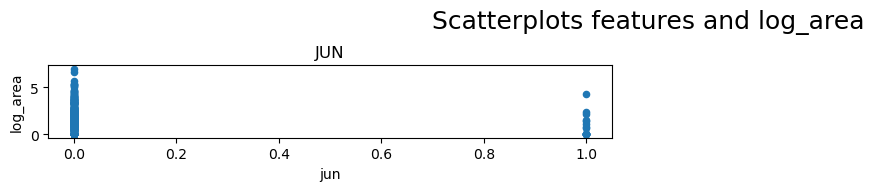

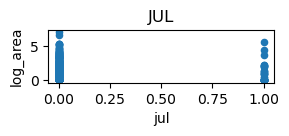

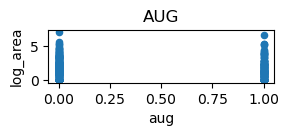

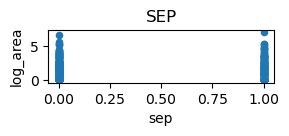

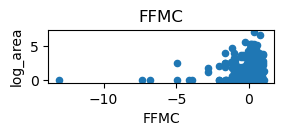

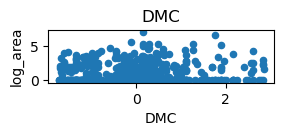

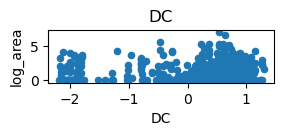

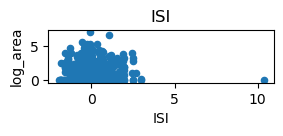

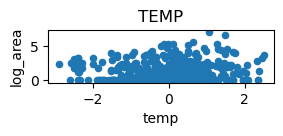

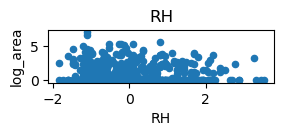

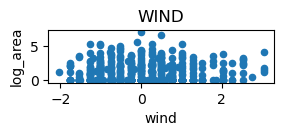

In [70]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Scatterplots features and log_area", fontsize=18, y=0.95)
for i,col in enumerate(final_df):
    ax= plt.subplot(6,2, i+1)
    scatter_df.plot.scatter(col, "log_area", ax=ax)
    ax.set_title(col.upper())
    plt.show()
    

## Spline transformer

In [77]:
spline = SplineTransformer(degree=1, n_knots=2)
spline_reg = spline.fit_transform(final_df)
lm.fit(spline_reg, y)


LinearRegression()

In [ ]:
spline_cv= cross_val_score(lm, spline_reg, y, cv = 5, scoring = "neg_mean_squared_error")
print("Spline_cv mean and standard deviation of cv:", np.mean(spline_cv), "|", np.std(spline_cv))

Spline_cv mean and standard deviation of cv: -2.4333210487968415 | 1.177934560940901
